# **PHOTOGRAPHIC RECIPE SEARCH**

Daniel Lu, Kooresh Akhbari, Defne Dilbaz, Yousif Alfuraiji

APS360 Team 32

**Important Team Notes**

*   This Google Colab file is in a shared folder called APS360-Project. Please make sure to copy this folder to your home directory on Google Drive — that is, the path to this file should be `drive/My Drive/APS360-Project/Project.ipynb` for everybody.



**Preliminary Code**

Code that needs to be run at the beginning of every project.

In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
!pip install split-folders
import split_folders
import os

In [4]:
print("HI")

HI


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
!unzip 'ingredients.zip' -d 'datasets_3b'

Archive:  ingredients.zip
  inflating: datasets_3b/almond/almond nut_1.jpg  
  inflating: datasets_3b/almond/almond nut_10.jpg  
  inflating: datasets_3b/almond/almond nut_100.jpg  
  inflating: datasets_3b/almond/almond nut_101.jpg  
  inflating: datasets_3b/almond/almond nut_103.jpg  
  inflating: datasets_3b/almond/almond nut_104.jpg  
  inflating: datasets_3b/almond/almond nut_105.jpg  
  inflating: datasets_3b/almond/almond nut_106.jpg  
  inflating: datasets_3b/almond/almond nut_107.jpg  
  inflating: datasets_3b/almond/almond nut_108.jpg  
  inflating: datasets_3b/almond/almond nut_109.jpg  
  inflating: datasets_3b/almond/almond nut_11.jpg  
  inflating: datasets_3b/almond/almond nut_110.jpg  
  inflating: datasets_3b/almond/almond nut_111.jpg  
  inflating: datasets_3b/almond/almond nut_112.jpg  
  inflating: datasets_3b/almond/almond nut_113.jpg  
  inflating: datasets_3b/almond/almond nut_114.jpg  
  inflating: datasets_3b/almond/almond nut_116.jpg  
  inflating: datasets_3b

**Code to Apply Transforms**

https://pytorch.org/docs/stable/torchvision/transforms.html

The ```apply_transform``` function is meant to apply a series of transforms. Passing in a list of numbers will apply those transforms, in the order that they are passed in. The table of transforms is given below.

```
 num | description            
  0  | no transform
  1  | random rotation
  2  | random brightness adjustment
  3  | grayscale
  4  | horizontal flip
  5  | vertical flip
  6  | random contrast adjustment
  7  | random hue adjustment
  8  | random saturation adjustment
```

For example, passing in ```num = [1,3,4]``` will return the ingredients dataset where each ingredient image has been randomly rotated, then greyscaled, then horizontally flipped.

If baseline is specified as True, the images will be scaled down to 50x50px. 

In [11]:
def get_transform(num):
    """
    Helper function for apply_transform

    Parameters:
        num (int): number corresponding to transforms (see table above)
    
    Returns:
        Transform: transform (see table above)
    """
    transform = {
        1:transforms.RandomRotation(180),
        2:transforms.ColorJitter(brightness=0.3),
        3:transforms.Grayscale(3),
        4:transforms.RandomHorizontalFlip(p=1.0),
        5:transforms.RandomVerticalFlip(p=1.0),
        6:transforms.ColorJitter(contrast=0.2),
        7:transforms.ColorJitter(hue=0.1),
        8:transforms.ColorJitter(saturation=0.1)
    }
    return transform.get(num)


def apply_transform(nums, baseline=False):
    """
    Applies a list of input transforms in order on a dataset.

    Parameters:
        nums (list): A list of numbers representing transforms (see table above).
        baseline (bool): Whether this loader is being used for the baseline model or not
    
    Returns:
        ImageFolder: Ingredient dataset with the transforms applied in order.
    """

    # Create the array of transforms based on the input numbers
    transform_list = []
    if (baseline):
        transform_list.append(transforms.Resize((50,50)))
    else:
        transform_list.append(transforms.CenterCrop(200))
    for n in nums:
        if 1 <= n <= 8:
            transform_list.append(get_transform(n))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

    # Initialize the transform object from the lsit of transforms
    transform = transforms.Compose(transform_list)

    # Load all ingredient with the given transform
    ingredient_dataset = datasets.ImageFolder(
        root = 'datasets_3b',
        transform = transform
    )

    return ingredient_dataset

**Code for Augmenting and Loading Data**

The ```get_data_loader``` function returns the training, validation, and test loaders that will be used to train the neural network. 

In [7]:
def get_transformed_data(transformations, baseline=False):
    """
    Gets a dataset of all the transformations that the user specified

    Parameters:
        transformations (list): List of transformations that will be applied
        baseline (bool): Whether this function is being used for the baseline model or not

    Returns: List of datasets that got transformations applied
    """
    data_set = []
    transformations.append([0])
    
    for transforms in transformations:
        data_set.append(apply_transform(transforms, baseline))
    return data_set

In [8]:
def shuffle_indices(list_indicies):
    np.random.seed(1250)

    np.random.shuffle(list_indicies)

    list_len = len(list_indicies)
    train_cutoff = int(list_len * 0.6)
    val_cutoff = int(list_len * 0.8)

    train_indx_shuffled = list_indicies[:train_cutoff]
    val_indx_shuffled = list_indicies[train_cutoff:val_cutoff]
    test_indx_shuffled = list_indicies[val_cutoff:]

    return train_indx_shuffled, val_indx_shuffled, test_indx_shuffled

In [9]:
def get_data_loader(trans_list, batch_size, baseline=False):
    """
    Gets the training, validation, and test loaders.

    Parameters: 
        trans_list (list): List of lists that contains the transformations to be applied
                          eg: [[1,2,3], [1,4,2]]  
        batch_size (int): Desired batch size
        baseline (bool): Whether this function is being used for the baseline model or not
    
    Returns:
        DataLoader, DataLoader, DataLoader: training, validation, and test DataLoaders
    """

    classes = ['almond', 'apple', 'asparagus', 'bacon', 'banana', 'beef_ground',
               'beef_steak', 'beet', 'blueberries', 'brussel_sprout', 'bun_hamburger',
               'bun_hotdog', 'butter', 'cabbage', ' carrot', 'cauliflower', 'celery',
               'cheese_block', 'cheese_shredded', 'chicken_breast', 'chicken_leg',
               'chicken_wing', 'corn', 'croissant', 'cucumber', 'egg', 'garlic',
               'ginger', 'grape', 'honey', 'ketchup', 'lemon', 'lobster', 'mango',
               'mayonnaise', 'milk', 'mushroom', 'mustard', 'noodle', 'oil_vegetable', 
               'onion', 'orange', 'peach', 'pear', 'pepper_bell', 'pepper_chile', 
               'pineapple', 'potato', 'rice', 'salmon', 'sausage', 'scallion',
               'shrimp', 'spaghetti', 'spinach', 'thyme', 'tomato', 'vinegar']
    

    list_dataset = get_transformed_data(trans_list, baseline)
    #Concatenate the datasets into one big dataset
    dataset = ConcatDataset(list_dataset)

    print("Total number of pictures after transformataions: " + str(len(dataset)))

    #Shuffle indicies
    train_indices, val_indices, test_indices = shuffle_indices(list(range(len(dataset))))

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    #Load the data
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=test_sampler)
    

    print('Len train_loader: ', len(train_loader))
    print('Len val_loader: ', len(val_loader))
    print('Len test_loader: ', len(test_loader))

    if (baseline):
        print('All DataLoaders initialized for baseline model')
    else:
        print('All DataLoaders initialized for full neural network')

    return train_loader, val_loader, test_loader, classes

**Code to Get DataLoaders for Baseline Model**

The following code initializes the train_loader, val_loader, and test_loader for the baseline model (50x50px images) and the full neural network (200x200px images). Once run, these values can be used directly in training the baseline model.

All labels in the DataLoaders are numerical figure (ex. 0 = almond, 1 = apple, etc.). The ```classes``` variable maps label numbers to ingredient names (ex. ```classes[0]``` will return ```'almond'```).

This code also prints the size of each DataLoader and the total number of pictures.

In [12]:
transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
batch = 32
train_loader_baseline, val_loader_baseline, test_loader_baseline, classes = get_data_loader(transformations_apply, batch_size=batch, baseline=True)
train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, batch)

Total number of pictures after transformataions: 74872
Len train_loader:  1404
Len val_loader:  468
Len test_loader:  468
All DataLoaders initialized for baseline model
Total number of pictures after transformataions: 84231
Len train_loader:  1580
Len val_loader:  527
Len test_loader:  527
All DataLoaders initialized for full neural network


**Code to Verify Images**

**THIS CODE DOES NOT NEED TO BE RUN.** The following code just visualizes some of the images in train_loader to make sure they are of acceptable quality. None of the following variables will be used anymore for the project.

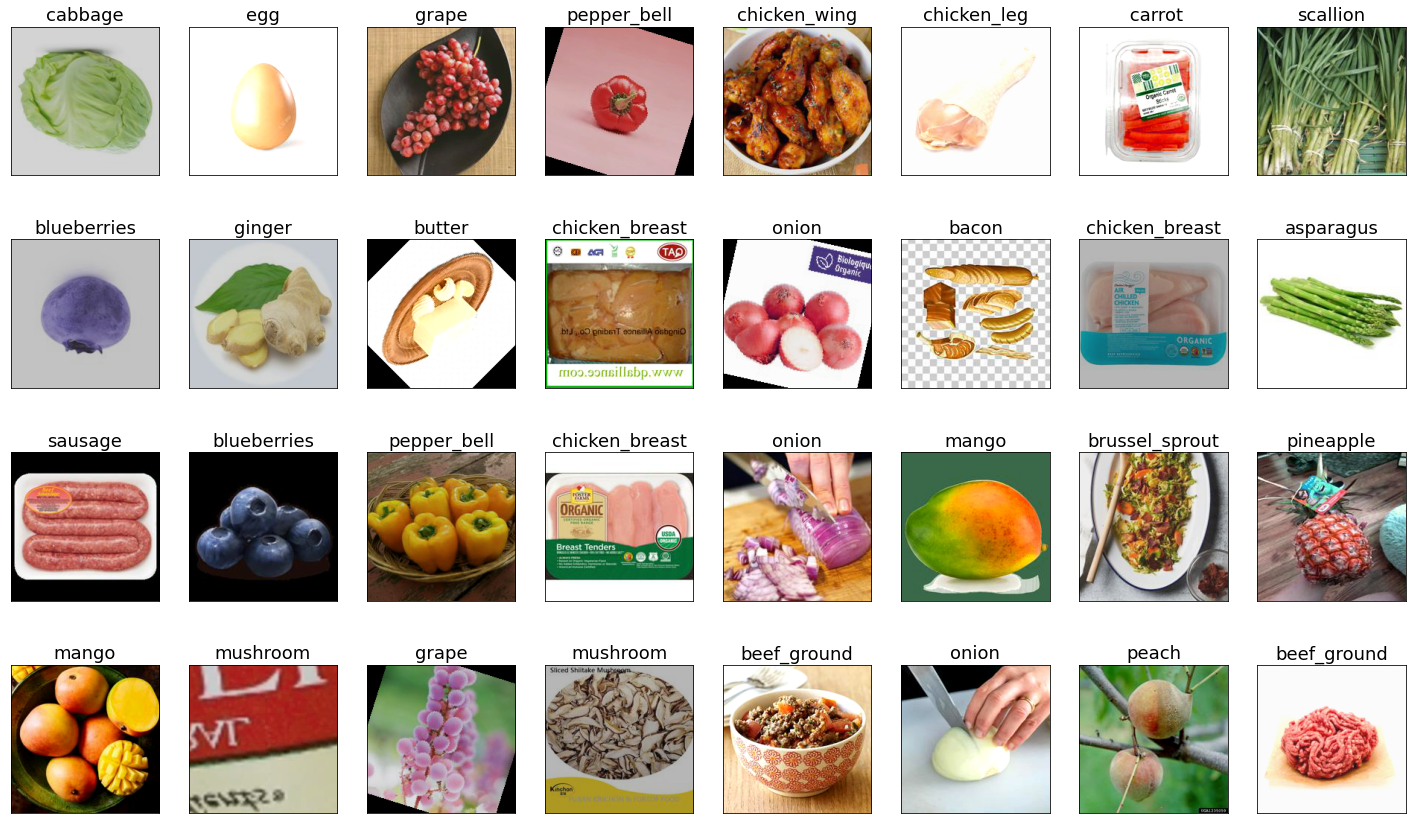

In [13]:
# THIS CODE DOES NOT NEED TO BE RUN

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
images = images / 2 + 0.5
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,15))
for idx in np.arange(32):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]], fontsize=18)

**Baseline Model**

NOTES TO YOUSIF AND DEFNE:

* Please make a local copy of the APS360-Project for training. MAKE SURE IT IS LOCAL!
* Please read all of the annotations above! You don't have to touch any of the above code, just run it (if you encounter issues, message Kooresh or Daniel)
* By running all of the above code, train_loader, val_loader, and test_loader have been initialized. Use these DataLoaders to train your code.
* Please remember to keep track of all architectures you train in https://docs.google.com/spreadsheets/d/1oQcA4yKam8iQfyHtsZV9JOXIjvXUS3MCSUgjVc9QBIU/edit?usp=sharing

**Code to Train a Given Model**

The following trains a model, saves the new parameters, and plots the resulting performance.

Note: `get_data_loader` function is called in train to keep the batch size consistent everytime.

Another note: we might want to randomize the `transformations_apply` vector inside of the train function later.

In [14]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    dir_path = name + "-bs" + str(batch_size) + "-lr" + str(learning_rate) + "-e" + str(epoch)
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
    path = dir_path + "/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_accuracy(model, data_loader):
    """ Calculates accuracy for a given model and a given data_loader
    Args:
      model: ANN model
      data_loader: one of val_loader, train_loader, test_loader, etc
    Returns:
      correct/total = correct labelled images/ total number of images
    """
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation acc/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = train_acc.size # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

        # labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def train(model, batch_size=32, num_epochs=1, learning_rate=1e-2, baseline=False):

    
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Load the Data
    transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
    train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, batch_size, baseline)

    # Set the loss and optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc, val_acc, train_loss, val_loss= [], [], [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    count = 0
    total_time = 0
    for epoch in range(num_epochs):

        # get start time to see how fast your model is for each epoch
        start_time = time.time()
        cur_time = time.time()
        total_train_loss = 0.0
        train_iterations = 0
        for imgs, labels in iter(train_loader):
            
            count += 1
            if (count % 10 == 0):
              print("{0} elapsed time: {1}".format(count, time.time()-cur_time))
            cur_time = time.time()
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()
            train_iterations += 1
        
        total_val_loss = 0.0
        val_iterations = 0

        count = 0
        for imgs, labels in iter(val_loader):
          
            count += 1
            # print(count)
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            val_iterations += 1
        
        train_acc[epoch] = get_accuracy(model, train_loader)
        train_loss[epoch] = float(total_train_loss) / train_iterations
        val_acc[epoch] = get_accuracy(model, val_loader)
        val_loss[epoch] = float(total_val_loss) / val_iterations

        total_time += time.time()-start_time

        print("epoch: ", epoch)
        print("Elapsed time: {0}".format(time.time()-start_time))
        print("train acc: {0} train loss: {1} val acc: {2} val loss: {3}".format(train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Average time per epoch: {0}".format(total_time/num_epochs))

    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs - 1)
    plot_training_curve(model_path)    

**Code for Baseline Model**

Let's define a very basic model and test it

In [16]:
torch.manual_seed(1) # set the random seed

# define a very basic neural network
class Baseline(nn.Module):
    def __init__(self):
        self.name = "baseline"
        super(Baseline, self).__init__()
        self.layer1 = nn.Linear(3 * 50 * 50, 1000)
        self.layer2 = nn.Linear(1000, len(classes))
    def forward(self, img):
        flattened = img.view(-1, 3 * 50 * 50)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

class Baseline2(nn.Module):
    def __init__(self):
        self.name = "baseline"
        super(Baseline2, self).__init__()
        self.layer1 = nn.Linear(3 * 50 * 50, len(classes))
    def forward(self, img):
        flattened = img.view(-1, 3 * 50 * 50)
        activation1 = self.layer1(flattened)
        return activation1

class Baseline3(nn.Module):
    def __init__(self):
        # width = int(input("Width: "))
        super(Baseline3, self).__init__()
        print("Width: ", width)
        self.name = "baseline"
        self.conv1 = nn.Conv2d(3, width, 5)
        self.pool1 = nn.MaxPool2d(4,3)
        self.conv2 = nn.Conv2d(width, 10, 6)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(5 * 5 * 10, len(classes))
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 10)
        x = self.fc1(x)
        return x


58
Width:  25
Using CUDA
Total number of pictures after transformataions: 74872
Len train_loader:  88
Len val_loader:  30
Len test_loader:  30
All DataLoaders initialized for baseline model
10 elapsed time: 0.7468063831329346
20 elapsed time: 0.9564380645751953
30 elapsed time: 1.0589122772216797
40 elapsed time: 0.8061614036560059
50 elapsed time: 0.809852123260498
60 elapsed time: 0.9272892475128174
70 elapsed time: 0.9960763454437256
80 elapsed time: 0.7646059989929199
epoch:  0
Elapsed time: 201.00519800186157
train acc: 0.04910624846960354 train loss: 3.916648244315928 val acc: 0.04848403900093495 val loss: 3.899167370796204
40 elapsed time: 1.0486700534820557
50 elapsed time: 0.9719529151916504
60 elapsed time: 1.0616369247436523
70 elapsed time: 0.8565158843994141
80 elapsed time: 0.7969546318054199
90 elapsed time: 1.0783209800720215
100 elapsed time: 0.8466842174530029
110 elapsed time: 0.9335169792175293
epoch:  1
Elapsed time: 221.04881596565247
train acc: 0.0977672906974155

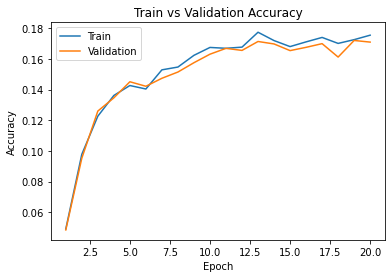

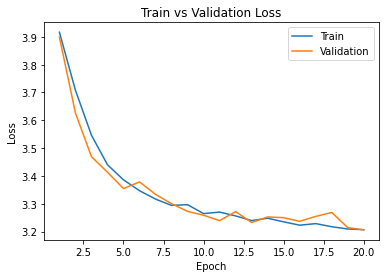

In [18]:
# 58 classes - baseline3 - 1 epoch
print(len(classes))
width = 25
some = Baseline3()


use_cuda = True
if use_cuda and torch.cuda.is_available():
  some.cuda()
  print("Using CUDA")


train(some, batch_size = 512, num_epochs = 20, baseline=True)

Let's initalize the baseline model and train and see how we do.

58
Width:  25
Using CUDA
Total number of pictures after transformataions: 74896
Len train_loader:  88
Len val_loader:  30
Len test_loader:  30
All DataLoaders initialized for baseline model
10 elapsed time: 1.3647794723510742
20 elapsed time: 60.78470015525818
30 elapsed time: 30.86757183074951
40 elapsed time: 18.618111848831177
50 elapsed time: 11.490352153778076
60 elapsed time: 3.020921468734741
70 elapsed time: 2.266359567642212
80 elapsed time: 2.0808956623077393
epoch:  0
Elapsed time: 1455.9016690254211
train acc: 0.07960032934997886 train loss: 3.916878507895903 val acc: 0.07523866746778823 val loss: 3.761799462636312
Average time per epoch: 1455.9014654159546


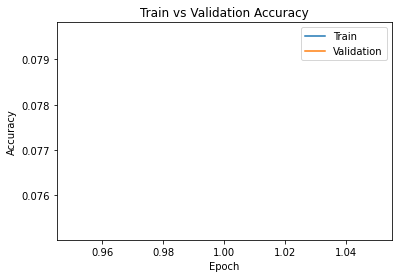

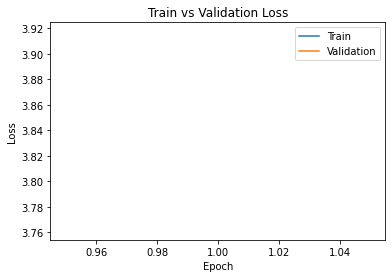

In [39]:
# 58 classes - baseline3 - 20 epochs
print(len(classes))
width = 25
some = Baseline3()


use_cuda = True
if use_cuda and torch.cuda.is_available():
  some.cuda()
  print("Using CUDA")


train(some, batch_size = 512, num_epochs = 1, baseline=True)

In [26]:
!sudo mv 'drive/My Drive/Colab Notebooks/APS360/PROJECT/Data_ALL/Ingredients/vinegar' 'drive/My Drive/Colab Notebooks/APS360/PROJECT/Data/Ingredients/'


Width:  30
Using CUDA
Total number of pictures after transformataions: 3504
Len train_loader:  66
Len val_loader:  22
Len test_loader:  22
All DataLoaders initialized for baseline model
epoch:  0
Elapsed time: 14.463624000549316
train acc: 0.7059942911512845 train loss: 0.870170712019458 val acc: 0.7075606276747504 val loss: 0.6291680972684514
epoch:  1
Elapsed time: 14.371859550476074
train acc: 0.6760228353948621 train loss: 0.7334752195712292 val acc: 0.6776034236804565 val loss: 0.7600046071139249
epoch:  2
Elapsed time: 14.454619646072388
train acc: 0.7150333016175071 train loss: 0.6767954270948063 val acc: 0.6890156918687589 val loss: 0.6638993891802701
epoch:  3
Elapsed time: 14.644683361053467
train acc: 0.7759276879162702 train loss: 0.6127452186562798 val acc: 0.7574893009985735 val loss: 0.6279155882922086
epoch:  4
Elapsed time: 14.301388502120972
train acc: 0.8035204567078973 train loss: 0.5812291132681298 val acc: 0.7689015691868759 val loss: 0.5283673757856543
epoch:  5


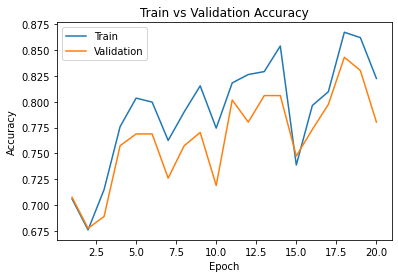

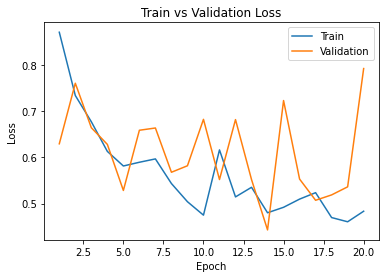

Width:  35
Using CUDA
Total number of pictures after transformataions: 3504
Len train_loader:  66
Len val_loader:  22
Len test_loader:  22
All DataLoaders initialized for baseline model
epoch:  0
Elapsed time: 14.380173444747925
train acc: 0.5280685061845861 train loss: 1.0197741190592449 val acc: 0.5534950071326676 val loss: 0.9746877740729939
epoch:  1
Elapsed time: 14.261664628982544
train acc: 0.49429115128449097 train loss: 0.9524033150889657 val acc: 0.5064194008559201 val loss: 0.9029896611517126
epoch:  2
Elapsed time: 14.352312803268433
train acc: 0.6384395813510942 train loss: 0.8732951509230065 val acc: 0.630527817403709 val loss: 0.7751740271394904
epoch:  3
Elapsed time: 14.24283218383789
train acc: 0.6379638439581351 train loss: 0.7653225795789198 val acc: 0.6333808844507846 val loss: 0.6962920088659633
epoch:  4
Elapsed time: 14.310161828994751
train acc: 0.6322549952426261 train loss: 0.7756162777994619 val acc: 0.6219686162624821 val loss: 0.6945805305784399
epoch:  5


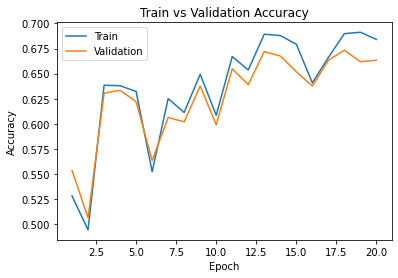

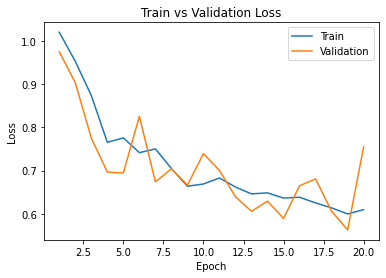

Width:  40
Using CUDA
Total number of pictures after transformataions: 3504
Len train_loader:  66
Len val_loader:  22
Len test_loader:  22
All DataLoaders initialized for baseline model
epoch:  0
Elapsed time: 14.180531978607178
train acc: 0.6436726926736441 train loss: 0.8933014093023358 val acc: 0.6547788873038516 val loss: 0.7080563604831696
epoch:  1
Elapsed time: 14.263721704483032
train acc: 0.647954329210276 train loss: 0.7877700970028386 val acc: 0.651925820256776 val loss: 0.7029843181371689
epoch:  2
Elapsed time: 14.506749629974365
train acc: 0.6117982873453853 train loss: 0.6802030020590984 val acc: 0.5977175463623395 val loss: 0.7233561196110465
epoch:  3
Elapsed time: 14.23351526260376
train acc: 0.6665080875356802 train loss: 0.6947131089188836 val acc: 0.6476462196861626 val loss: 0.6713230569254268
epoch:  4
Elapsed time: 14.327566385269165
train acc: 0.6294005708848716 train loss: 0.7538118023764003 val acc: 0.6005706134094151 val loss: 0.6922202516685833
epoch:  5
El

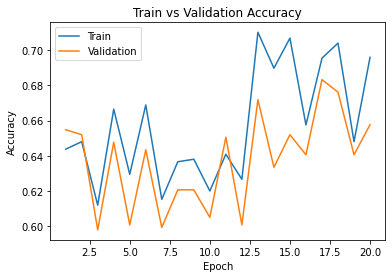

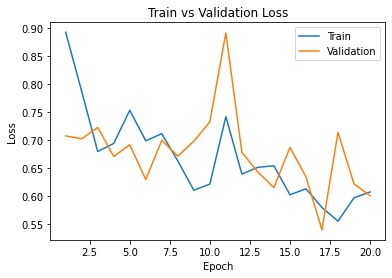

In [ ]:
widths = [30, 35, 40]

for w in widths:
    width = w
    model = Baseline3()

    use_cuda = True
    if use_cuda and torch.cuda.is_available():
      model.cuda()
      print("Using CUDA")


    train(model, num_epochs = 20, baseline=True)

Using CUDA
Total number of pictures after transformataions: 3504
Len train_loader:  66
Len val_loader:  22
Len test_loader:  22
All DataLoaders initialized for baseline model
epoch:  0
Elapsed time: 14.912185192108154
train acc: 0.654138915318744 train loss: 15.804164552327359 val acc: 0.6219686162624821 val loss: 3.8504804968833923
epoch:  1
Elapsed time: 14.973192930221558
train acc: 0.7369172216936252 train loss: 1.9345512182423563 val acc: 0.7360912981455064 val loss: 1.1687961423938924
epoch:  2
Elapsed time: 14.636327981948853
train acc: 0.6365366317792579 train loss: 5.712190847053672 val acc: 0.6048502139800286 val loss: 6.65058846636252
epoch:  3
Elapsed time: 14.599760293960571
train acc: 0.7045670789724072 train loss: 9.503545960693648 val acc: 0.666191155492154 val loss: 6.356824430552396
epoch:  4
Elapsed time: 14.752671003341675
train acc: 0.7126546146527117 train loss: 10.665402803457145 val acc: 0.6961483594864479 val loss: 4.8375024768439205
epoch:  5
Elapsed time: 14.

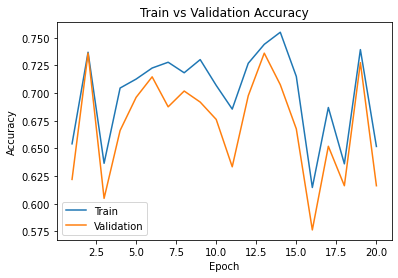

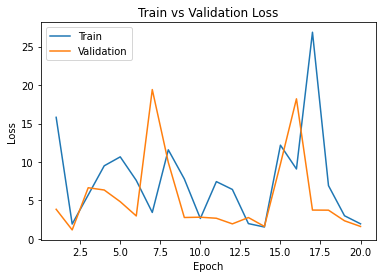

In [ ]:
model = Baseline()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, num_epochs = 20, baseline=True)

Using CUDA
Total number of pictures after transformataions: 3504
Len train_loader:  66
Len val_loader:  22
Len test_loader:  22
All DataLoaders initialized for baseline model
epoch:  0
Elapsed time: 14.830841302871704
train acc: 0.69790675547098 train loss: 4.277313393173796 val acc: 0.6419400855920114 val loss: 2.667614991014654
epoch:  1
Elapsed time: 14.890949726104736
train acc: 0.6379638439581351 train loss: 3.069463523951444 val acc: 0.6362339514978602 val loss: 4.394695813005621
epoch:  2
Elapsed time: 14.59616470336914
train acc: 0.7269267364414843 train loss: 3.0852276890566857 val acc: 0.6704707560627675 val loss: 2.8678077080033044
epoch:  3
Elapsed time: 14.580918550491333
train acc: 0.8087535680304472 train loss: 2.5217957496643066 val acc: 0.7318116975748931 val loss: 1.8501627336848865
epoch:  4
Elapsed time: 14.660431146621704
train acc: 0.7597526165556613 train loss: 2.242735216563398 val acc: 0.703281027104137 val loss: 2.2983798912980338
epoch:  5
Elapsed time: 14.75

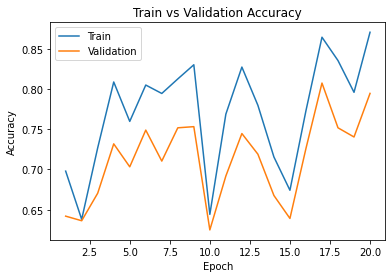

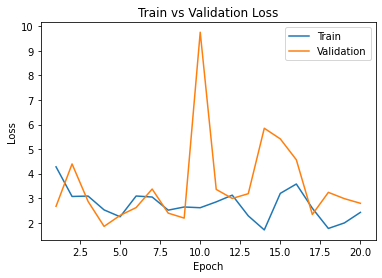

In [ ]:
model = Baseline2()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, num_epochs = 20, baseline=True)